In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy.stats as stats
import random

import utilities as ut
import modularised_utils as mut

sns.set_theme(style="whitegrid")
seed = 42
np.random.seed(seed)

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [2]:
experiment = 'lilucas'
path = f"data/{experiment}"
saved_folds = joblib.load(f"data/{experiment}/cv_folds.pkl")

In [3]:
# Load the dictionaries containing the results for each optimization method
diroca_results = joblib.load(f"{path}/diroca_cv_results.pkl")
gradca_results = joblib.load(f"{path}/gradca_cv_results.pkl")
baryca_results = joblib.load(f"{path}/baryca_cv_results.pkl")

print("Successfully loaded results for all optimization methods.")
print(f"  - DIROCA results keys: {list(diroca_results.keys())}")
print(f"  - GradCA results keys: {list(gradca_results.keys())}")
print(f"  - BARYCA results keys: {list(baryca_results.keys())}")

results_to_evaluate = {
                            "DIROCA": diroca_results,
                            "GradCA": gradca_results,
                            "BARYCA": baryca_results
                        }

Successfully loaded results for all optimization methods.
  - DIROCA results keys: ['fold_0', 'fold_1']
  - GradCA results keys: ['fold_0', 'fold_1']
  - BARYCA results keys: ['fold_0', 'fold_1']


In [4]:
# Load the original data dictionary
all_data      = ut.load_all_data(experiment)

Dll_samples   = all_data['LLmodel']['data']
Dhl_samples   = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
omega         = all_data['abstraction_data']['omega']
ll_var_names  = list(all_data['LLmodel']['graph'].nodes())
hl_var_names  = list(all_data['HLmodel']['graph'].nodes())

Data loaded for 'lilucas'.


In [5]:
def calculate_abstraction_error(T_matrix, Dll_test, Dhl_test):
    """
    Calculates the abstraction error for a given T matrix on a test set.

    This function works in the space of distribution parameters:
    1. It estimates Gaussian parameters (mean, cov) from the LL and HL test samples.
    2. It transforms the LL Gaussian's parameters using the T matrix.
    3. It computes the Wasserstein distance between the transformed LL distribution
       and the actual HL distribution.
    
    Args:
        T_matrix (np.ndarray): The learned abstraction matrix.
        Dll_test (np.ndarray): The low-level endogenous test samples.
        Dhl_test (np.ndarray): The high-level endogenous test samples.
        
    Returns:
        float: The calculated Wasserstein-2 distance.
    """
    # 1. Estimate parameters from the low-level test data
    mu_L_test    = np.mean(Dll_test, axis=0)
    Sigma_L_test = np.cov(Dll_test, rowvar=False)

    # 2. Estimate parameters from the high-level test data
    mu_H_test    = np.mean(Dhl_test, axis=0)
    Sigma_H_test = np.cov(Dhl_test, rowvar=False)

    # 3. Transform the low-level parameters using the T matrix
    # This projects the low-level distribution into the high-level space
    mu_V_predicted    = mu_L_test @ T_matrix.T
    Sigma_V_predicted = T_matrix @ Sigma_L_test @ T_matrix.T
    
    # 4. Compute the Wasserstein distance between the two resulting Gaussians
    try:
        wasserstein_dist = np.sqrt(mut.compute_wasserstein(mu_V_predicted, Sigma_V_predicted, mu_H_test, Sigma_H_test))
    except Exception as e:
        print(f"  - Warning: Could not compute Wasserstein distance. Error: {e}. Returning NaN.")
        return np.nan

    return wasserstein_dist

In [6]:

def apply_shift(clean_data, shift_config, all_var_names, model_level, seed=42):
    """
    Applies a specified contamination to the test data.
    - Handles different shift types (additive, multiplicative).
    - Handles different distributions (gaussian, student-t, exponential).
    - Handles selective application to a subset of variables.
    """
    # np.random.seed(seed)
    shift_type = shift_config.get('type')
    dist_type = shift_config.get('distribution', 'gaussian')
    n_samples, n_dims = clean_data.shape

    # Select the correct parameter dictionary for the current model level
    level_key = 'll_params' if model_level == 'L' else 'hl_params'
    params = shift_config.get(level_key, {})
    
    # --- 1. Generate the full noise matrix based on the specified distribution ---
    noise_matrix = np.zeros_like(clean_data)
    if dist_type == 'gaussian':
        mu = np.array(params.get('mu', np.zeros(n_dims)))
        sigma_def = params.get('sigma', np.eye(n_dims))
        sigma = np.diag(np.array(sigma_def)) if np.array(sigma_def).ndim == 1 else np.array(sigma_def)
        noise_matrix = np.random.multivariate_normal(mean=mu, cov=sigma, size=n_samples)

    elif dist_type == 'student-t':
        df = params.get('df', 3)
        loc = np.array(params.get('loc', np.zeros(n_dims)))
        shape_def = params.get('shape', np.eye(n_dims))
        shape = np.diag(np.array(shape_def)) if np.array(shape_def).ndim == 1 else np.array(shape_def)
        noise_matrix = stats.multivariate_t.rvs(loc=loc, shape=shape, df=df, size=n_samples)

    elif dist_type == 'exponential':
        scale = params.get('scale', 1.0)
        noise_matrix = np.random.exponential(scale=scale, size=(n_samples, n_dims))
    
    # --- 2. Apply noise selectively if specified ---
    final_noise = np.zeros_like(clean_data)
    vars_to_affect = params.get('apply_to_vars')

    if vars_to_affect is None:
        # If not specified, apply noise to all variables
        final_noise = noise_matrix
    else:
        # If specified, apply noise only to the selected columns
        try:
            indices_to_affect = [all_var_names.index(var) for var in vars_to_affect]
            final_noise[:, indices_to_affect] = noise_matrix[:, indices_to_affect]
        except ValueError as e:
            print(f"Warning: A variable in 'apply_to_vars' not found. Error: {e}")
            return clean_data # Return clean data if there's a config error

    # --- 3. Return the contaminated data ---
    if shift_type == 'additive':
        return clean_data + final_noise
    elif shift_type == 'multiplicative':
        return clean_data * final_noise
    else:
        raise ValueError(f"Unknown shift type: {shift_type}")

In [7]:
def apply_huber_contamination(clean_data, alpha, shift_config, all_var_names, model_level, seed=42):
    """
    Contaminates a dataset using the Huber model. A fraction 'alpha' of the
    samples are replaced with noisy versions.

    Args:
        clean_data (np.ndarray): The original, clean test data samples.
        alpha (float): The fraction of data to contaminate (between 0 and 1).
        shift_config (dict): Configuration defining the noise for the outliers.
        all_var_names (list): List of all variable names for this data.
        model_level (str): 'L' for low-level or 'H' for high-level.
        
    Returns:
        np.ndarray: The new, contaminated test data.
    """
    # np.random.seed(seed)
    if not (0 <= alpha <= 1):
        raise ValueError("Alpha must be between 0 and 1.")

    if alpha == 0:
        return clean_data
    
    # Create the fully noisy version of the data using our existing function
    noisy_data = apply_shift(clean_data, shift_config, all_var_names, model_level)
    
    if alpha == 1:
        return noisy_data
        
    n_samples = clean_data.shape[0]
    n_to_contaminate = int(alpha * n_samples)
    
    # Randomly select which rows to replace
    indices_to_replace = np.random.choice(n_samples, n_to_contaminate, replace=False)
    
    # Start with a copy of the clean data
    contaminated_data = clean_data.copy()
    
    # Replace the selected rows with their noisy versions
    contaminated_data[indices_to_replace] = noisy_data[indices_to_replace]
    
    return contaminated_data

In [8]:
def plot_robustness_curves(results_df):
    """
    Plots the abstraction error as a function of contamination strength for each method.
    """
    plt.figure(figsize=(12, 8))
    
    sns.lineplot(
        data=results_df, 
        x='noise_scale', 
        y='error', 
        hue='method', 
        marker='o',
        errorbar=('ci', 95) # Show 95% confidence interval
    )
    
    plt.title('Robustness Curve: Abstraction Error vs. Noise Level', fontsize=16)
    plt.xlabel('Contamination Strength (Noise Scale)', fontsize=12)
    plt.ylabel('Average Abstraction Error (Wasserstein Distance)', fontsize=12)
    plt.legend(title='Method')
    plt.grid(True, which='both', linestyle='--')
    plt.show()


def perform_statistical_tests(results_df, method1, method2, test_type='paired-t'):
    """
    Compares two methods at each noise level using a statistical test.
    """
    print(f"\n--- Statistical Significance Test: {method1} vs. {method2} ({test_type}) ---")
    
    df_sorted = results_df.sort_values('fold')
    noise_levels = sorted(df_sorted['noise_scale'].unique())
    
    for level in noise_levels:
        df_level = df_sorted[df_sorted['noise_scale'] == level]
        
        errors1 = df_level[df_level['method'] == method1]['error'].dropna()
        errors2 = df_level[df_level['method'] == method2]['error'].dropna()

        if len(errors1) != len(errors2) or len(errors1) < 2:
            print(f"  - At Noise Level {level:.2f}: Not enough data to perform test.")
            continue
            
        # Perform statistical test
        if test_type == 'paired-t':
            stat, p_value = stats.ttest_rel(errors1, errors2)
        elif test_type == 'wilcoxon':
            # Wilcoxon is for paired, non-parametric data
            stat, p_value = stats.wilcoxon(errors1, errors2)
        else: # Independent t-test
            stat, p_value = stats.ttest_ind(errors1, errors2)

        # Report the result
        print(f"  - At Noise Level {level:.2f}: p-value = {p_value:.4f}", end="")
        if p_value < 0.05:
            winner = method1 if np.mean(errors1) < np.mean(errors2) else method2
            print(f" (Significant difference, {winner} is better)")
        else:
            print(" (No significant difference)")

# End-to-End Huber Evaluation

In [9]:
# Define the fraction of data to contaminate (0=0-shift, 1=rho-shift)
alpha_values = np.linspace(0, 1.0, 10)

# Define the contamination strength for the outliers
noise_levels = np.linspace(0, 10.0, 10) 

# Define how many random noise draws to average over for each setting
num_trials = 3 # A higher number gives a more stable estimate

# Define base covariance matrices
base_sigma_L = np.eye(len(all_data['LLmodel']['graph'].nodes()))
base_sigma_H = np.eye(len(all_data['HLmodel']['graph'].nodes()))


evaluation_records = []

# --- Loop 1: Iterate through each contamination fraction ---
for alpha in tqdm(alpha_values):
    
    # --- Loop 2: Iterate through each contamination strength ---
    for scale in noise_levels:
        
        # --- Loop 3: Iterate through multiple random samples ---
        for trial in range(num_trials):
            
            # This loop runs the full k-fold test for a single trial
            for i, fold_info in enumerate(saved_folds):
                for method_name, results_dict in results_to_evaluate.items():
                    fold_results = results_dict[f'fold_{i}']
                    for run_key, run_data in fold_results.items():

                        T_learned = run_data['T_matrix']
                        test_indices = run_data['test_indices']
                        
                        # The avg error across interventions for this single trial & fold
                        errors_per_intervention = []
                        for iota in I_ll_relevant:
                            Dll_test_clean = Dll_samples[iota][test_indices]
                            Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
                            
                            shift_config = {
                                'type': 'additive', 'distribution': 'gaussian',
                                'll_params': {'mu': np.zeros(base_sigma_L.shape[0]), 'sigma': base_sigma_L * (scale**2)},
                                'hl_params': {'mu': np.zeros(base_sigma_H.shape[0]), 'sigma': base_sigma_H * (scale**2)}
                            }
                            
                            Dll_test_contaminated = apply_huber_contamination(Dll_test_clean, alpha, shift_config, ll_var_names, 'L')
                            Dhl_test_contaminated = apply_huber_contamination(Dhl_test_clean, alpha, shift_config, hl_var_names, 'H')
                            
                            error = calculate_abstraction_error(T_learned, Dll_test_contaminated, Dhl_test_contaminated)
                            if not np.isnan(error):
                                errors_per_intervention.append(error)
                        
                        avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
                        
                        # Store a detailed record for every trial and every fold
                        record = {
                            'method': method_name,
                            'run_id': run_key,
                            'alpha': alpha,
                            'noise_scale': scale,
                            'trial': trial,
                            'fold': i,
                            'error': avg_error
                        }
                        evaluation_records.append(record)

# Convert all records into a single DataFrame
final_results_df = pd.DataFrame(evaluation_records)
print("--- Full Evaluation Complete ---")

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [04:01<00:00, 24.18s/it]

--- Full Evaluation Complete ---


In [10]:
# 1. First, calculate the summary statistics DataFrame using groupby and agg
print("--- Final Summary (Mean Error ± Std Dev across all folds) ---")
# Corrected line
summary_stats = final_results_df.groupby(['method', 'run_id'])['error'].agg(['mean', 'std']).sort_values('mean')
# Display the raw summary DataFrame
display(summary_stats)


# 2. Now, print the results in your custom table format
print("\n" + "="*60)
print(f"{'Method/Run':<35} | {'Mean Error ± Std Dev'}")
print("="*60)

for index, row in summary_stats.iterrows():
    # Unpack the multi-index
    method, run_id = index
    
    mean_val = row['mean']
    std_val = row['std']
    
    # Create a clean name for display in the table
    display_name = f"{method} ({run_id})"
    
    print(f"{display_name:<35} | {mean_val:>7.4f} ± {std_val:.4f}")

print("="*60)

--- Final Summary (Mean Error ± Std Dev across all folds) ---


mean        std
method run_id                              
DIROCA eps_delta_4      7.243092   1.399329
       eps_delta_8      7.542655   1.394178
       eps_delta_2     13.273206   8.301465
       eps_delta_1     14.618404   9.423999
BARYCA baryca_run      25.980777  19.700918
DIROCA eps_delta_0.14  29.025376  22.256828
GradCA gradca_run      33.628819  22.957745


Method/Run                          | Mean Error ± Std Dev
DIROCA (eps_delta_4)                |  7.2431 ± 1.3993
DIROCA (eps_delta_8)                |  7.5427 ± 1.3942
DIROCA (eps_delta_2)                | 13.2732 ± 8.3015
DIROCA (eps_delta_1)                | 14.6184 ± 9.4240
BARYCA (baryca_run)                 | 25.9808 ± 19.7009
DIROCA (eps_delta_0.14)             | 29.0254 ± 22.2568
GradCA (gradca_run)                 | 33.6288 ± 22.9577


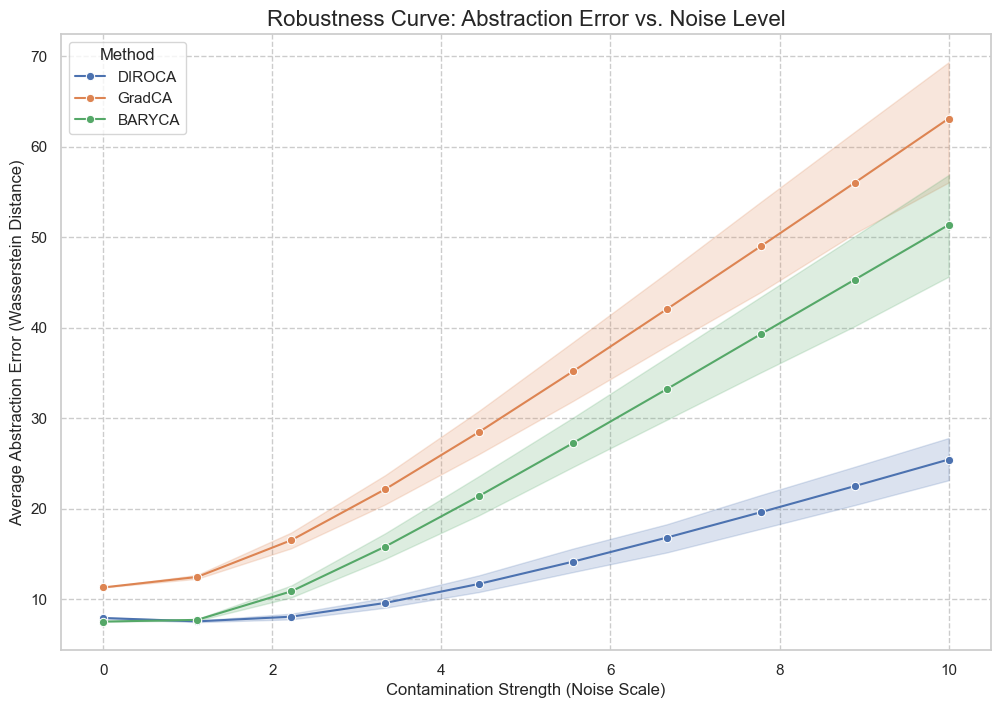


--- Statistical Significance Test: DIROCA vs. GradCA (paired-t) ---
  - At Noise Level 0.00: Not enough data to perform test.
  - At Noise Level 1.11: Not enough data to perform test.
  - At Noise Level 2.22: Not enough data to perform test.
  - At Noise Level 3.33: Not enough data to perform test.
  - At Noise Level 4.44: Not enough data to perform test.
  - At Noise Level 5.56: Not enough data to perform test.
  - At Noise Level 6.67: Not enough data to perform test.
  - At Noise Level 7.78: Not enough data to perform test.
  - At Noise Level 8.89: Not enough data to perform test.
  - At Noise Level 10.00: Not enough data to perform test.

--- Statistical Significance Test: DIROCA vs. BARYCA (paired-t) ---
  - At Noise Level 0.00: Not enough data to perform test.
  - At Noise Level 1.11: Not enough data to perform test.
  - At Noise Level 2.22: Not enough data to perform test.
  - At Noise Level 3.33: Not enough data to perform test.
  - At Noise Level 4.44: Not enough data to perfo

In [11]:
# First, generate the main plot
plot_robustness_curves(final_results_df)

# Then, run statistical tests to compare pairs of methods
# A paired t-test is appropriate here because the methods are tested on the same k-fold splits.
perform_statistical_tests(final_results_df, 'DIROCA', 'GradCA', test_type='paired-t')
perform_statistical_tests(final_results_df, 'DIROCA', 'BARYCA', test_type='paired-t')

--- Robustness Curve for Alpha = 1.0 ---


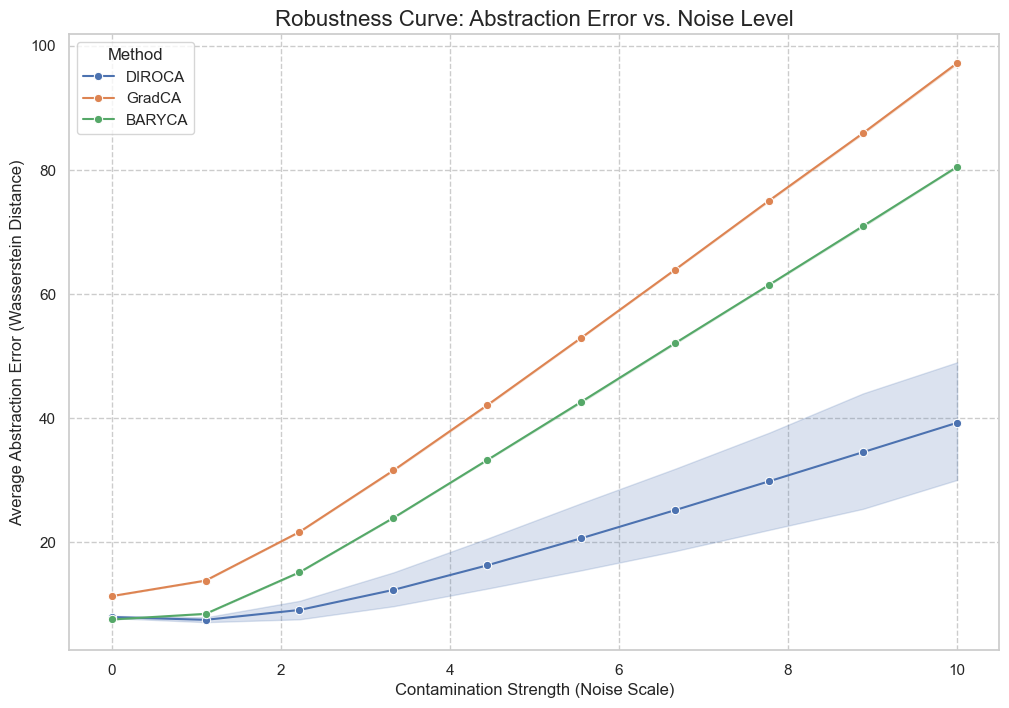

In [12]:
# In a new cell, you can filter your DataFrame and plot:
alpha_to_plot = 1.0
df_subset = final_results_df[final_results_df['alpha'] == alpha]

print(f"--- Robustness Curve for Alpha = {alpha} ---")
plot_robustness_curves(df_subset)

/var/folders/vn/9swzhgj513q7n9gd_4vsbd840000gn/T/ipykernel_37813/2114797874.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['display_name'] = df_filtered.apply(create_display_name, axis=1)


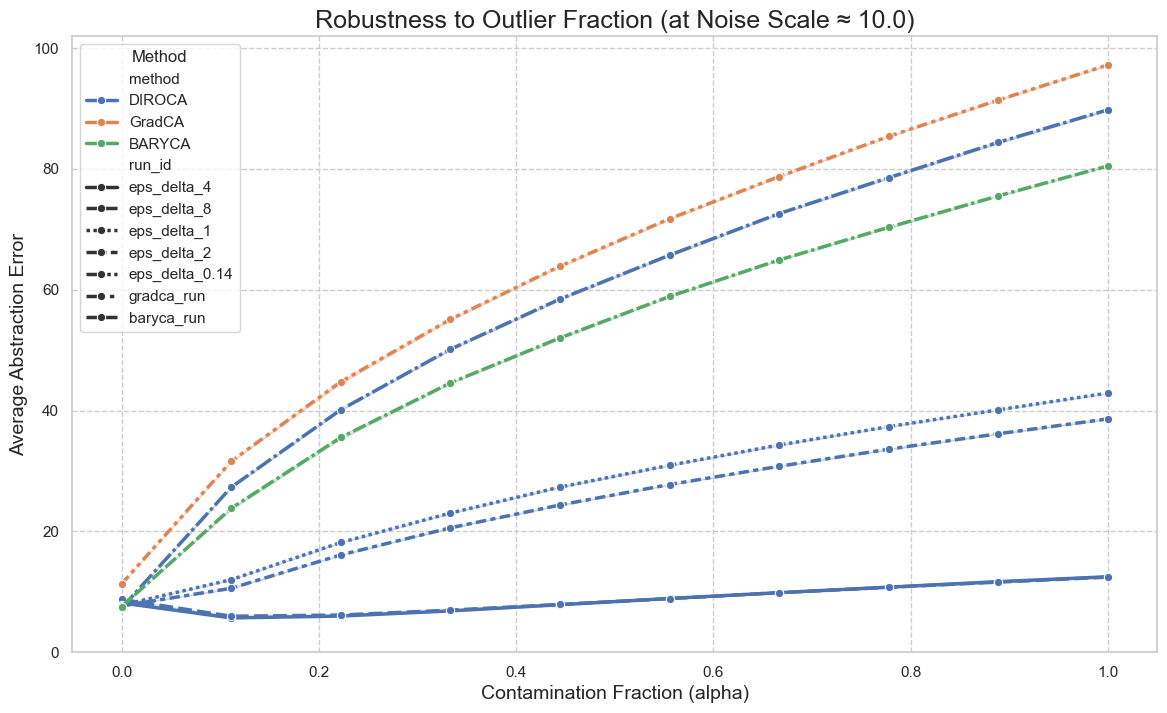

In [13]:
# Choose which noise level to analyze
noise_level_to_plot = 10.0

df_filtered = final_results_df[np.isclose(final_results_df['noise_scale'], noise_level_to_plot)]
def create_display_name(row):
    # For DIROCA, combine method and hyperparameter
    if row['method'] == 'DIROCA':
        return f"{row['method']} ({row['run_id']})"
    # For others, just use the method name
    return row['method']

df_filtered['display_name'] = df_filtered.apply(create_display_name, axis=1)
if df_filtered.empty:
    print(f"Warning: No data found for noise_scale ≈ {noise_level_to_plot}.")
    print("Please check the 'noise_levels' list in your experiment to ensure this value exists.")
else:
    plt.figure(figsize=(14, 8))
    
    sns.lineplot(
        data=df_filtered,
        x='alpha',
        y='error',
        hue='method',
        style='run_id',
        marker='o',
        linewidth=2.5,
        errorbar=('ci', 95) # The shaded area is the 95% confidence interval
    )

    plt.title(f'Robustness to Outlier Fraction (at Noise Scale ≈ {noise_level_to_plot})', fontsize=18)
    plt.xlabel('Contamination Fraction (alpha)', fontsize=14)
    plt.ylabel('Average Abstraction Error', fontsize=14)
    plt.legend(title='Method')
    plt.grid(True, which='both', linestyle='--')
    plt.ylim(bottom=0) 
    plt.show()

### Results visuals

In [14]:
# Set this to one of: 'robustness_curve', 'outlier_fraction_curve', or 'point_comparison'
analysis_mode = 'point_comparison'

# Used if analysis_mode = 'robustness_curve'
alpha_to_plot = 1.0

# Used if analysis_mode = 'outlier_fraction_curve'
noise_level_to_plot = 10.0 

# Used if analysis_mode = 'point_comparison'
alpha_point = 1.0
noise_level_point = 10.0

if analysis_mode == 'robustness_curve':
    print(f"--- Generating Robustness Curve for Alpha = {alpha_to_plot} ---")
    df_subset = final_results_df[np.isclose(final_results_df['alpha'], alpha_to_plot)]
    
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=df_subset, x='noise_scale', y='error', hue='method', style='run_id', marker='o', errorbar=('ci', 95))
    plt.title(f'Robustness to Noise Intensity (at Alpha = {alpha_to_plot})', fontsize=18)
    plt.xlabel('Contamination Strength (Noise Scale)', fontsize=14)
    plt.ylabel('Average Abstraction Error', fontsize=14)
    plt.legend(title='Method')
    plt.grid(True, which='both', linestyle='--')
    plt.show()

elif analysis_mode == 'outlier_fraction_curve':
    print(f"--- Generating Outlier Fraction Curve for Noise Scale = {noise_level_to_plot} ---")
    df_subset = final_results_df[np.isclose(final_results_df['noise_scale'], noise_level_to_plot)]
    
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=df_subset, x='alpha', y='error', hue='method', style='run_id', marker='o', errorbar=('ci', 95))
    plt.title(f'Robustness to Outlier Fraction (at Noise Scale ≈ {noise_level_to_plot})', fontsize=18)
    plt.xlabel('Contamination Fraction (alpha)', fontsize=14)
    plt.ylabel('Average Abstraction Error', fontsize=14)
    plt.legend(title='Method')
    plt.grid(True, which='both', linestyle='--')
    plt.show()

elif analysis_mode == 'point_comparison':
    print(f"--- Generating Point Comparison for Alpha={alpha_point}, Noise Scale={noise_level_point} ---")
    
    df_subset = final_results_df[
        (np.isclose(final_results_df['alpha'], alpha_point)) &
        (np.isclose(final_results_df['noise_scale'], noise_level_point))
    ]
    
    summary_table = df_subset.groupby(['method', 'run_id'])['error'].agg(['mean', 'std', 'count'])
    
    # Calculate the Standard Error of the Mean (SEM)
    summary_table['sem'] = summary_table['std'] / np.sqrt(summary_table['count'])
    
    print("\nPerformance under this specific condition (with SEM):")
    display(summary_table)

    # Mean ± SEM
    print("\n" + "="*65)
    print(f"{'Method/Run':<35} | {'Mean Error ± Standard Error of Mean (SEM)'}")
    print("="*65)

    for index, row in summary_table.iterrows():
        display_name = f"{row.name[0]} ({row.name[1]})"
        mean_val = row['mean']
        sem_val = row['sem']
        
        print(f"{display_name:<35} | {mean_val:>7.4f} ± {sem_val:.4f}")
    print("="*65)

# Statistical tests
perform_statistical_tests(df_subset, 'DIROCA', 'GradCA')
perform_statistical_tests(df_subset, 'DIROCA', 'BARYCA')

--- Generating Point Comparison for Alpha=1.0, Noise Scale=10.0 ---

Performance under this specific condition (with SEM):


mean       std  count       sem
method run_id                                              
BARYCA baryca_run      16.356847  0.084743      6  0.034596
DIROCA eps_delta_0.14  22.027036  0.121324      6  0.049530
       eps_delta_1      7.800341  0.090215      6  0.036830
       eps_delta_2      4.824349  0.044315      6  0.018092
       eps_delta_4      4.489243  0.080994      6  0.033066
       eps_delta_8      4.496858  0.120560      6  0.049218
GradCA gradca_run      21.961286  0.135321      6  0.055245


Method/Run                          | Mean Error ± Standard Error of Mean (SEM)
BARYCA (baryca_run)                 | 16.3568 ± 0.0346
DIROCA (eps_delta_0.14)             | 22.0270 ± 0.0495
DIROCA (eps_delta_1)                |  7.8003 ± 0.0368
DIROCA (eps_delta_2)                |  4.8243 ± 0.0181
DIROCA (eps_delta_4)                |  4.4892 ± 0.0331
DIROCA (eps_delta_8)                |  4.4969 ± 0.0492
GradCA (gradca_run)                 | 21.9613 ± 0.0552

--- Statistical Significance Test: DIROCA vs. GradCA (paired-t) ---
  - At Noise Level 10.00: Not enough data to perform test.

--- Statistical Significance Test: DIROCA vs. BARYCA (paired-t) ---
  - At Noise Level 10.00: Not enough data to perform test.


## F-contamination

In [15]:
def contaminate_data(data, strength, contamination_type, num_segments=10, seed=None):
    """
    Applies a specified contamination to data samples to simulate model misspecification.

    Args:
        data (np.ndarray): The original data samples.
        strength (float): The magnitude of the contamination.
        contamination_type (str): 'piecewise', 'multiplicative', or 'nonlinear'.
        num_segments (int): Number of segments for the 'piecewise' type.
        seed (int, optional): Random seed for reproducibility.
        
    Returns:
        np.ndarray: The contaminated data.
    """
    rng = np.random.default_rng(seed)
    data_cont = data.copy()
    
    if contamination_type == "multiplicative":
        # Apply element-wise multiplicative noise
        noise = rng.uniform(low=1.0 - strength, high=1.0 + strength, size=data.shape)
        data_cont *= noise
  
    elif contamination_type == "nonlinear":
        # Apply a sine-based non-linear distortion
        data_cont += strength * np.sin(data_cont)
  
    elif contamination_type == "piecewise":
        # Apply piecewise contamination to each column (variable)
        for col_idx in range(data.shape[1]):
            column = data_cont[:, col_idx]
            breakpoints = np.quantile(column, q=np.linspace(0, 1, num_segments + 1))
            breakpoints[-1] += 1e-6 # Ensure the last element is included
            
            for i in range(num_segments):
                factor = 1.0 + rng.uniform(low=-strength, high=strength)
                mask = (column >= breakpoints[i]) & (column < breakpoints[i+1])
                data_cont[mask, col_idx] *= factor
  
    else:
        raise ValueError(f"Unknown contamination type: {contamination_type}")
  
    return data_cont

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:08<00:00,  2.25it/s]




--- F-Misspecification Evaluation Complete ---


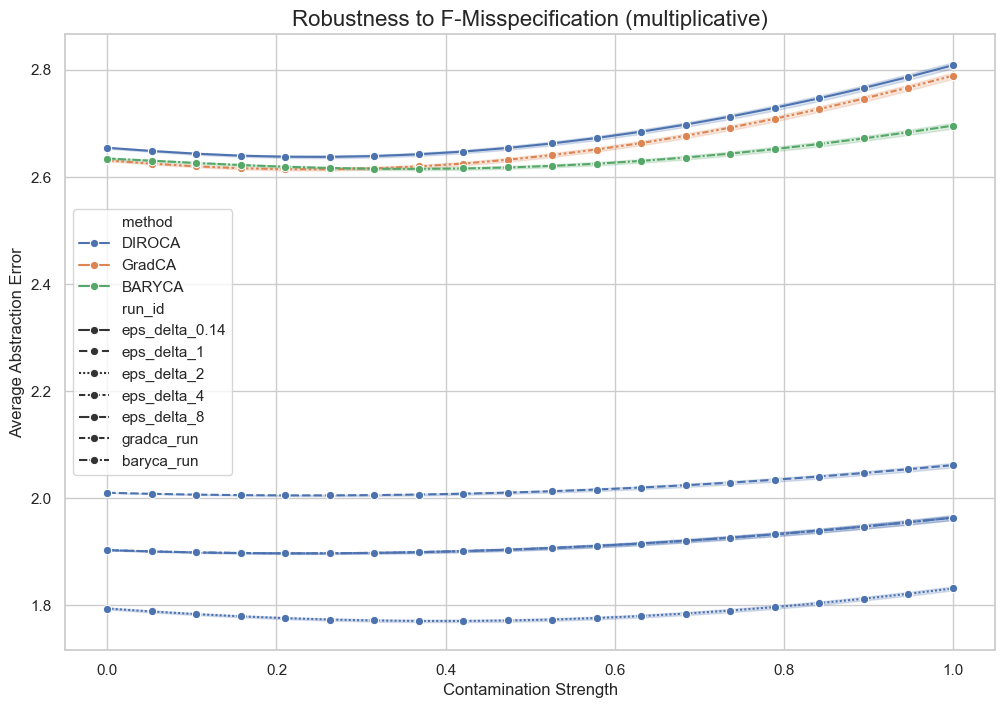


Overall Performance (Averaged Across All 'multiplicative' Strengths)
Method/Run                          | Mean Error ± 95% CI
BARYCA (baryca_run)                 | 2.6363 ± 0.0033
DIROCA (eps_delta_0.14)             | 2.6853 ± 0.0074
DIROCA (eps_delta_1)                | 2.0205 ± 0.0025
DIROCA (eps_delta_2)                | 1.7874 ± 0.0025
DIROCA (eps_delta_4)                | 1.9156 ± 0.0029
DIROCA (eps_delta_8)                | 1.9156 ± 0.0029
GradCA (gradca_run)                 | 2.6635 ± 0.0076


In [16]:
# Choose which type of non-linearity to test
contamination_type_to_run = 'multiplicative' # Options: 'piecewise', 'multiplicative', 'nonlinear'

# Define the range of contamination strengths to test
contamination_strengths = np.linspace(0, 1, 20) 

# Number of random contaminations to average over for each setting
num_trials = 5

f_spec_records = []

# --- Loop 1: Iterate through each contamination strength ---
for strength in tqdm(contamination_strengths):
    
    # --- Loop 2: Iterate through multiple random trials ---
    for trial in range(num_trials):
        
        # --- Loop 3: Iterate through each cross-validation fold ---
        for i, fold_info in enumerate(saved_folds):
            for method_name, results_dict in results_to_evaluate.items():
                fold_results = results_dict[f'fold_{i}']
                for run_key, run_data in fold_results.items():

                    T_learned = run_data['T_matrix']
                    test_indices = run_data['test_indices']
                    
                    # The avg error across interventions for this single trial & fold
                    errors_per_intervention = []
                    for iota in I_ll_relevant:
                        Dll_test_clean = Dll_samples[iota][test_indices]
                        Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
                        
                        # Trial number as a seed for a new random contamination
                        Dll_test_cont = contaminate_data(Dll_test_clean, strength, contamination_type_to_run, seed=trial)
                        Dhl_test_cont = contaminate_data(Dhl_test_clean, strength, contamination_type_to_run, seed=trial)
                        
                        error = calculate_abstraction_error(T_learned, Dll_test_cont, Dhl_test_cont)
                        if not np.isnan(error):
                            errors_per_intervention.append(error)
                    
                    avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
                    
                    # Store a detailed record
                    record = {
                        'method': method_name,
                        'run_id': run_key,
                        'contamination': strength,
                        'trial': trial,
                        'fold': i,
                        'error': avg_error
                    }
                    f_spec_records.append(record)

f_spec_df = pd.DataFrame(f_spec_records)
print("\n\n--- F-Misspecification Evaluation Complete ---")

# --- a. Plot the Robustness Curve ---
plt.figure(figsize=(12, 8))
sns.lineplot(data=f_spec_df, x='contamination', y='error', hue='method', style='run_id', marker='o', errorbar=('ci', 95))
plt.title(f'Robustness to F-Misspecification ({contamination_type_to_run})', fontsize=16)
plt.xlabel('Contamination Strength', fontsize=12)
plt.ylabel('Average Abstraction Error', fontsize=12)
plt.show()

# --- b. Print the Final Summary Table ---
print("\n" + "="*65)
print(f"Overall Performance (Averaged Across All '{contamination_type_to_run}' Strengths)")
print("="*65)
print(f"{'Method/Run':<35} | {'Mean Error ± 95% CI'}")
print("="*65)

summary = f_spec_df.groupby(['method', 'run_id'])['error'].agg(['mean', 'std', 'count'])
summary['sem'] = summary['std'] / np.sqrt(summary['count'])
summary['ci95'] = 1.96 * summary['sem']

for index, row in summary.iterrows():
    display_name = f"{row.name[0]} ({row.name[1]})"
    print(f"{display_name:<35} | {row['mean']:.4f} ± {row['ci95']:.4f}")
print("="*65)

## ω contamination

In [17]:
def contaminate_omega_map(original_omega, num_misalignments):
    """Randomly re-wires a subset of entries in the omega map."""
    
    # Get a list of interventions that can be changed (i.e., are not None)
    valid_keys = [k for k in original_omega.keys() if k is not None]
    
    if not valid_keys: return original_omega.copy()
        
    contaminated_omega = original_omega.copy()
    num_to_corrupt = min(num_misalignments, len(valid_keys))
    
    # Randomly select interventions to misalign
    keys_to_corrupt = random.sample(valid_keys, k=num_to_corrupt)
    
    # Get the list of all possible high-level targets
    all_hl_targets = list(set(val for val in original_omega.values() if val is not None))
    
    for key in keys_to_corrupt:
        original_target = contaminated_omega[key]
        # Find potential new targets that are different from the original
        available_new_targets = [t for t in all_hl_targets if t != original_target]
        
        if available_new_targets:
            # Reassign to a random, incorrect target
            contaminated_omega[key] = random.choice(available_new_targets)
            
    return contaminated_omega

100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


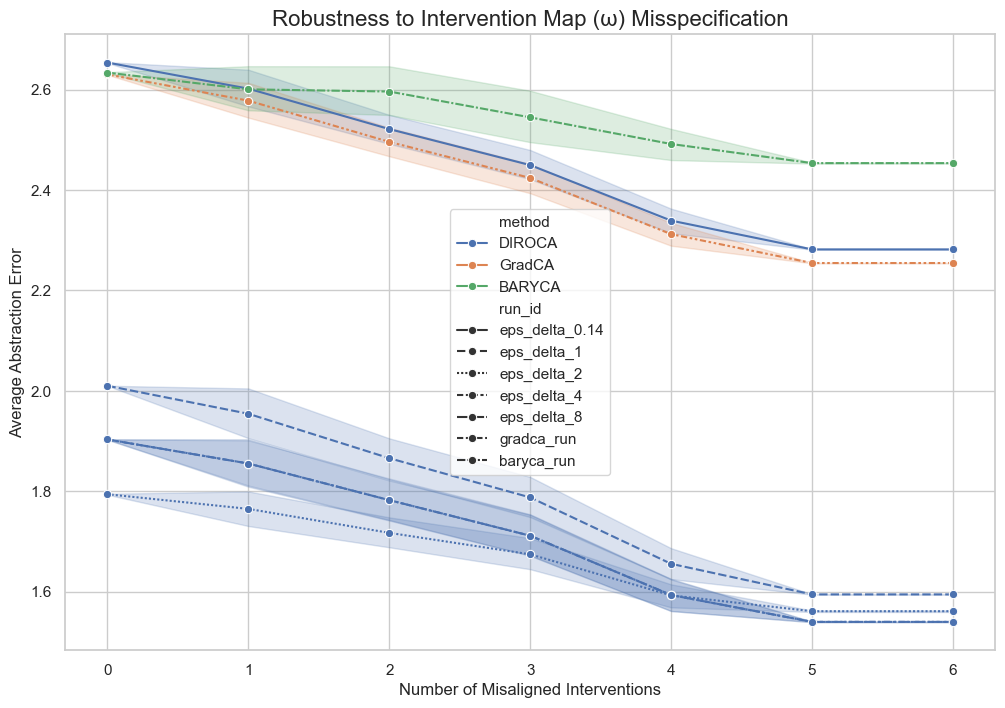


Overall Performance (Averaged Across All Misalignment Levels)
Method/Run                          | Mean Error ± Std Dev

--- Overall Omega-Misspecification Performance ---
BARYCA (baryca_run)                 | 2.5498 ± 0.0163
DIROCA (eps_delta_0.14)             | 2.4645 ± 0.0213
DIROCA (eps_delta_1)                | 1.7993 ± 0.0249
DIROCA (eps_delta_2)                | 1.6767 ± 0.0151
DIROCA (eps_delta_4)                | 1.7202 ± 0.0227
DIROCA (eps_delta_8)                | 1.7202 ± 0.0227
GradCA (gradca_run)                 | 2.4389 ± 0.0215


In [18]:
max_misalignments   = len(I_ll_relevant)
misalignment_levels = np.linspace(0, max_misalignments, 10, dtype=int)

num_trials           = 10

omega_spec_records = []
for num_misalignments in tqdm(misalignment_levels):
    for trial in range(num_trials):
        # Create a new scrambled omega map for each trial
        omega_cont = contaminate_omega_map(omega, num_misalignments)
        
        for i, fold_info in enumerate(saved_folds):
            for method_name, results_dict in results_to_evaluate.items():
                fold_results = results_dict[f'fold_{i}']
                for run_key, run_data in fold_results.items():
                    T_learned, test_indices = run_data['T_matrix'], run_data['test_indices']
                    
                    errors_per_intervention = []
                    for iota in I_ll_relevant:
                        Dll_test = Dll_samples[iota][test_indices]
                        # Use the contaminated omega map
                        Dhl_test = Dhl_samples[omega_cont[iota]][test_indices]
                        
                        error = calculate_abstraction_error(T_learned, Dll_test, Dhl_test)
                        if not np.isnan(error): errors_per_intervention.append(error)
                    
                    avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
                    omega_spec_records.append({'method': method_name, 'run_id': run_key, 'misalignments': num_misalignments, 'error': avg_error})

omega_spec_df = pd.DataFrame(omega_spec_records)
# Calculate final summary table, averaging across all misalignment levels
omega_final_summary = omega_spec_df.groupby(['method', 'run_id'])['error'].agg(['mean', 'std', 'count'])
omega_final_summary['sem'] = omega_final_summary['std'] / np.sqrt(omega_final_summary['count'])
omega_final_summary['ci95'] = 1.96 * omega_final_summary['sem']

plt.figure(figsize=(12, 8))
sns.lineplot(data=omega_spec_df, x='misalignments', y='error', hue='method', style='run_id', marker='o', errorbar=('ci', 95))
plt.title('Robustness to Intervention Map (ω) Misspecification', fontsize=16)
plt.xlabel('Number of Misaligned Interventions', fontsize=12)
plt.ylabel('Average Abstraction Error', fontsize=12)
plt.show()

print("\n" + "="*65)
print("Overall Performance (Averaged Across All Misalignment Levels)")
print("="*65)
print(f"{'Method/Run':<35} | {'Mean Error ± Std Dev'}")
print("="*65)

# Print the final formatted table
print("\n--- Overall Omega-Misspecification Performance ---")
for index, row in omega_final_summary.iterrows():
    display_name = f"{row.name[0]} ({row.name[1]})"
    print(f"{display_name:<35} | {row['mean']:.4f} ± {row['ci95']:.4f}")